In [2]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import os
import time
import Levenshtein
import distance
import textdistance
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np

In [3]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [4]:
# Process the image

# img = open("test1.png", "rb")
img = open("images/test2.jpeg", "rb")
read_response = computervision_client.read_in_stream(
    image=img,
    mode="Printed",
    raw=True
)
operation_id = read_response.headers['Operation-Location'].split('/')[-1]
while True:
    read_result = computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

# Print the detected text, line by line
result = []
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            print(line.text)
            result.append(line.text)

print()

Lucces in resolvarea
TEMELOR la
LABORA toarele de
Inteligenta Artificialà!



In [5]:
# get/define the ground truth
# groundTruth = ["Google Cloud", "Platform"]
groundTruth = ["Succes in rezolvarea", "tEMELOR la", "LABORAtoaree de", "Inteligenta Artificiala!"]

In [15]:
def calculate_cer_Levenshtein(reference_text, recognized_text):
    reference_text = reference_text.lower()
    recognized_text = recognized_text.lower()
    cer = Levenshtein.distance(reference_text, recognized_text) / len(reference_text)
    return cer

def calculate_wer_Levenshtein(reference_text, recognized_text):
    reference_words = reference_text.lower().split()
    recognized_words = recognized_text.lower().split()
    wer = Levenshtein.distance(reference_words, recognized_words) / len(reference_words)
    return wer


cer = calculate_cer_Levenshtein(" ".join(groundTruth), " ".join(result))
wer = calculate_wer_Levenshtein(" ".join(groundTruth), " ".join(result))

print("Character Error Rate (CER):", cer)
print("Word Error Rate (WER):", wer)

Character Error Rate (CER): 0.06944444444444445
Word Error Rate (WER): 0.5555555555555556


In [16]:
def calculate_cer_hamming(reference_text, recognized_text):
    reference_text = reference_text.lower()
    recognized_text = recognized_text.lower()
    max_length = max(len(reference_text), len(recognized_text))
    reference_text = reference_text.ljust(max_length)
    recognized_text = recognized_text.ljust(max_length)
    cer = distance.hamming(reference_text, recognized_text) / max_length
    return cer

def calculate_wer_hamming(reference_text, recognized_text):
    reference_words = reference_text.lower().split()
    recognized_words = recognized_text.lower().split()
    max_length = max(len(reference_words), len(recognized_words))
    reference_words += [''] * (max_length - len(reference_words))
    recognized_words += [''] * (max_length - len(recognized_words))
    wer = distance.hamming(reference_words, recognized_words) / max_length
    return wer


cer = calculate_cer_hamming(" ".join(groundTruth), " ".join(result))
wer = calculate_wer_hamming(" ".join(groundTruth), " ".join(result))

print("Character Error Rate (CER):", cer)
print("Word Error Rate (WER):", wer)

Character Error Rate (CER): 0.44594594594594594
Word Error Rate (WER): 0.7


In [17]:
def calculate_cer_jaro_winkler(reference_text, recognized_text):
    reference_text = reference_text.lower()
    recognized_text = recognized_text.lower()
    cer = 1 - textdistance.jaro_winkler(reference_text, recognized_text)
    return cer

def calculate_wer_jaro_winkler(reference_text, recognized_text):
    reference_words = reference_text.lower().split()
    recognized_words = recognized_text.lower().split()
    total_distance = sum(textdistance.jaro_winkler(ref, rec) for ref, rec in zip(reference_words, recognized_words))
    wer = 1 - total_distance / max(len(reference_words), len(recognized_words))
    return wer


cer = calculate_cer_jaro_winkler(" ".join(groundTruth), " ".join(result))
wer = calculate_wer_jaro_winkler(" ".join(groundTruth), " ".join(result))

print("Character Error Rate (CER):", cer)
print("Word Error Rate (WER):", wer)

Character Error Rate (CER): 0.1558487058487058
Word Error Rate (WER): 0.3243737373737374


In [18]:
def calculate_cer_lcs(reference_text, recognized_text):
    reference_text = reference_text.lower()
    recognized_text = recognized_text.lower()
    lcs_substrings = distance.lcsubstrings(reference_text, recognized_text)
    lcs_length = len(lcs_substrings)
    max_length = max(len(reference_text), len(recognized_text))
    cer = 1 - lcs_length / max_length
    return cer

def calculate_wer_lcs(reference_text, recognized_text):
    reference_words = reference_text.lower().split()
    recognized_words = recognized_text.lower().split()
    
    # Convert lists of words to strings separated by a delimiter
    reference_str = ','.join(reference_words)
    recognized_str = ','.join(recognized_words)
    
    # Get longest common substrings
    lcs_substrings = distance.lcsubstrings(reference_str, recognized_str)
    
    lcs_length = len(lcs_substrings)
    max_length = max(len(reference_words), len(recognized_words))
    wer = 1 - lcs_length / max_length
    return wer


cer = calculate_cer_lcs(" ".join(groundTruth), " ".join(result))
wer = calculate_wer_lcs(" ".join(groundTruth), " ".join(result))

print("Character Error Rate (CER):", cer)
print("Word Error Rate (WER):", wer)

Character Error Rate (CER): 0.9864864864864865
Word Error Rate (WER): 0.9


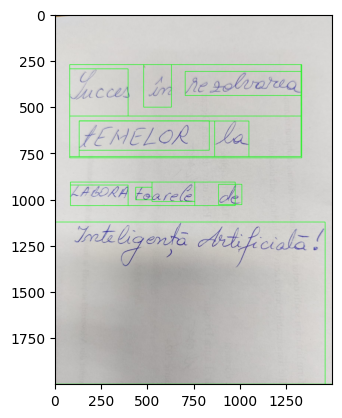

In [19]:
def detect_and_draw_bounding_boxes(image_path, output_image_path):
    image = cv2.imread(image_path)

    # Detect text using pytesseract
    if image_path == 'images/test1.png':
            custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
    if image_path == 'images/test2.jpeg':
            custom_config = r'--oem 1 --psm 4 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
    text = pytesseract.image_to_data(image, config=custom_config, output_type=pytesseract.Output.DICT)
    
    # Draw bounding boxes around the detected text
    for i in range(len(text['text'])):
        x, y, w, h = text['left'][i], text['top'][i], text['width'][i], text['height'][i]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    cv2.imwrite(output_image_path, image)


#detect_and_draw_bounding_boxes("images/test1.png", "images/test1_boxes.png")
detect_and_draw_bounding_boxes("images/test2.jpeg", "images/test2_boxes.jpeg")

# plot the image
#im = plt.imread("images/test1_boxes.png")
im = plt.imread("images/test2_boxes.jpeg")
fig = plt.imshow(im)
plt.show()

0.7478957616079938


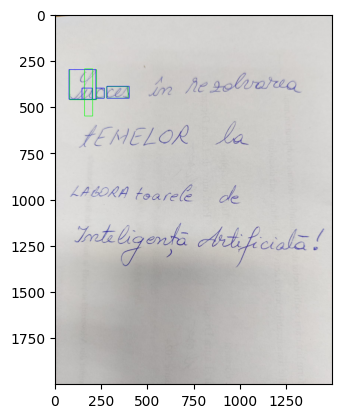

In [20]:
def intersection_over_union_bounding_boxes(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def quality_correct_localization(image, output_image_path, custom_config):    
    boxes = pytesseract.image_to_boxes(image, config=custom_config)

    i = 0
    s = 0
    for box in boxes.splitlines():
        i += 1
        if i < 5:
            box = box.split()
            x, y, w, h = map(int, box[1:5])
            cv2.rectangle(image, (x, image.shape[0] - y), (w, image.shape[0] - h), (0, 255, 0), 2)
            if i == 1:
                cv2.rectangle(image, (75, 300), (220, 460), (255, 0, 0), 2)
                s += intersection_over_union_bounding_boxes([x, image.shape[0] - h, w, image.shape[0] - y], [75, 300, 220, 460])
            if i == 2:
                cv2.rectangle(image, (145, 400), (200, 460), (255, 0, 0), 2)
                s += intersection_over_union_bounding_boxes([x, image.shape[0] - h, w, image.shape[0] - y], [145, 400, 200, 460])
            if i == 3:
                cv2.rectangle(image, (220, 400), (265, 455), (255, 0, 0), 2)
                s += intersection_over_union_bounding_boxes([x, image.shape[0] - h, w, image.shape[0] - y], [220, 400, 265, 455])
            if i == 4:
                cv2.rectangle(image, (280, 390), (400, 455), (255, 0, 0), 2)
                s += intersection_over_union_bounding_boxes([x, image.shape[0] - h, w, image.shape[0] - y], [280, 390, 400, 455])
                
    print(s/4)
    cv2.imwrite(output_image_path, image)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# Example usage
custom_config = r'--oem 1 --psm 4 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
image = cv2.imread('images/test2.jpeg')
quality_correct_localization(image, "images/test2_quality.jpeg", custom_config)

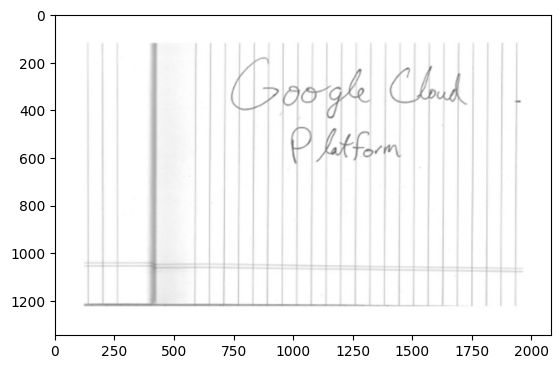

In [12]:
def image_blur(img):
    ret1, th1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3


def remove_noise_and_blur(img):
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    motion_blur_kernel = np.array([[0, 0, 1],
                                    [0, 1, 0],
                                    [1, 0, 0]], dtype=np.float32) / 3.0
    motion_blurred = cv2.filter2D(opening, -1, motion_blur_kernel)
    return motion_blurred


def process_image(image_path, target_dpi=300):
    image = cv2.imread(image_path)

    # Calculate the original image dimensions
    original_height, original_width = image.shape[:2]
    # Calculate the new dimensions based on the desired DPI
    target_width = int(original_width * (target_dpi / 72.0))
    target_height = int(original_height * (target_dpi / 72.0))
    target_size = (target_width, target_height)
    # Resize the image
    resized_image = cv2.resize(image, target_size)
    
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY) # Convert image to grayscale

    processed_image = remove_noise_and_blur(gray)

    cv2.imwrite("processed_image.png", processed_image) # Save the processed image
    return processed_image


processed_image = process_image("images/test1.png")

im = cv2.imread("images/processed_image.png")
fig = plt.imshow(im)
plt.show()

In [13]:
def read_printed_text_from_image(image_path, computervision_client):
    with open(image_path, "rb") as img:
        read_response = computervision_client.read_in_stream(
            image=img,
            mode="Printed",
            raw=True
        )
    
    operation_id = read_response.headers['Operation-Location'].split('/')[-1]
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    detected_text = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                detected_text.append(line.text)

    return detected_text


result = read_printed_text_from_image("images/processed_image2.png", computervision_client)
print(result)

['Lucces in resolvarea', 'TEMELOR la', 'LABORA toarele de', 'Inteligenta Artificialà!']


In [14]:
cer = calculate_cer_Levenshtein(" ".join(groundTruth), " ".join(result))
wer = calculate_wer_Levenshtein(" ".join(groundTruth), " ".join(result))

print("Character Error Rate (CER):", cer)
print("Word Error Rate (WER):", wer)

Character Error Rate (CER): 0.06944444444444445
Word Error Rate (WER): 0.5555555555555556
